In [1]:
import os
import sys
sys.path.insert(0, os.path.abspath('../'))
import IPython
import IPython.display
from ipywidgets import *
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import json
from tensorflow import keras
from keras import layers
from skimage.restoration import denoise_tv_chambolle

from andi_datasets.models_phenom import models_phenom
from andi_datasets.datasets_phenom import datasets_phenom
from andi_datasets.utils_trajectories import plot_trajs
from andi_datasets.utils_challenge import label_continuous_to_list

%matplotlib widget

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2024-05-31 16:33:41.752740: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 16:33:41.752779: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 16:33:41.752794: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-31 16:33:41.758710: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.0
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2024-05-31 16:33:42.841622: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-31 16:33:42.844829: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-31 16:33:42.844866: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0b:00.0/numa_node
Your kernel may have been built without NUMA support.


In [2]:
N = 10
T = 32
total_range = T+200

In [3]:
def uncumulate(xs:np.ndarray):
    assert xs.ndim == 1
    uncum_list = [0.]
    for i in range(1, len(xs)):
        uncum_list.append(xs[i] - xs[i-1])
    return np.array(uncum_list).copy()

In [4]:
def radius_list(xs:np.ndarray, ys:np.ndarray):
    assert xs.ndim == 1 and ys.ndim == 1
    rad_list = [0.]
    disp_list = []
    for i in range(1, len(xs)):
        rad_list.append(np.sqrt((xs[i] - xs[0])**2 + (ys[i] - ys[0])**2))
        disp_list.append(np.sqrt((xs[i] - xs[i-1])**2 + (ys[i] - ys[i-1])**2))
    return np.array(rad_list) / np.mean(disp_list) / len(xs)

In [5]:
def shuffle(data, *args):
    shuffle_index = np.arange(data.shape[0])
    np.random.shuffle(shuffle_index)
    args = list(args)
    for i, arg in enumerate(args):
        args[i] = arg[shuffle_index]
    return data[shuffle_index], *args

In [6]:
input_data = []
input_label = []

for alpha in np.arange(0.001, 2, 0.001):
    D = np.random.uniform(low=0.01, high=10.0)
    #alpha = np.random.choice([0.01, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 1.99], 1)[0]
    trajs_model, labels_model = models_phenom().single_state(N=N,
                                                             L=None,
                                                             T=total_range,
                                                             alphas=alpha,
                                                             Ds=[D, 0],
                                                            )
    for n_traj in range(N):
        #var_length = np.random.randint(-4, 4)
        xs = trajs_model[:, n_traj, 0][:T]
        ys = trajs_model[:, n_traj, 1][:T]
        rad_list = radius_list(xs, ys)
        
        xs = xs / (np.std(xs))
        xs = np.cumsum(abs(uncumulate(xs))) / T
        ys = ys / (np.std(ys))
        ys = np.cumsum(abs(uncumulate(ys))) / T
        
        input_list = np.vstack((((xs + ys) /2), rad_list)).T
        input_data.append(input_list)
        input_label.append(alpha)
        
        for _ in range(25):
            #var_length = np.random.randint(-4, 4)
            random_start = np.random.randint(10, total_range-T)
            xs = trajs_model[:, n_traj, 0][random_start:random_start + T]
            ys = trajs_model[:, n_traj, 1][random_start:random_start + T]
            rad_list = radius_list(xs, ys)
            
            xs = xs / (np.std(xs))
            xs = np.cumsum(abs(uncumulate(xs))) / T
            ys = ys / (np.std(ys))
            ys = np.cumsum(abs(uncumulate(ys))) / T
                    
            input_list = np.vstack((((xs + ys) /2), rad_list)).T
            input_data.append(input_list)
            input_label.append(alpha)
            
input_data = np.array(input_data)
input_label = np.array(input_label)

In [7]:
valid_data = []
valid_label = []

for alpha in np.arange(0.001, 2, 0.001):
    D = np.random.uniform(low=0.01, high=10.0)
    #alpha = np.random.choice([0.01, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 1.99], 1)[0]
    trajs_model, labels_model = models_phenom().single_state(N=3,
                                                             L=None,
                                                             T=total_range,
                                                             alphas=alpha,
                                                             Ds=[D, 0],
                                                            )
    for n_traj in range(3):        
        for _ in range(25):
            random_start = np.random.randint(0, total_range-T)
            xs = trajs_model[:, n_traj, 0][random_start:random_start + T]
            ys = trajs_model[:, n_traj, 1][random_start:random_start + T]
            rad_list = radius_list(xs, ys)
            
            xs = xs / (np.std(xs))
            xs = np.cumsum(abs(uncumulate(xs))) / T
            ys = ys / (np.std(ys))
            ys = np.cumsum(abs(uncumulate(ys))) / T
                    
            input_list = np.vstack((((xs + ys) /2), rad_list)).T
            valid_data.append(input_list)
            valid_label.append(alpha)
            
valid_data = np.array(valid_data)
valid_label = np.array(valid_label)

In [8]:
train_input, train_label = shuffle(input_data, input_label)
val_input, val_label = shuffle(valid_data, valid_label)

(519740, 32, 2) (519740,)


(array([2340., 2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600.,
        2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600.,
        2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600.,
        2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600.,
        2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600.,
        2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600.,
        2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600.,
        2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600.,
        2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600.,
        2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600.,
        2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600.,
        2600., 2600., 2600., 2860., 2600., 2600., 2600., 2600., 2600.,
        2600., 2600., 2600., 2600., 2600., 2600., 2600., 2340., 2600.,
        2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600., 2600.,
      

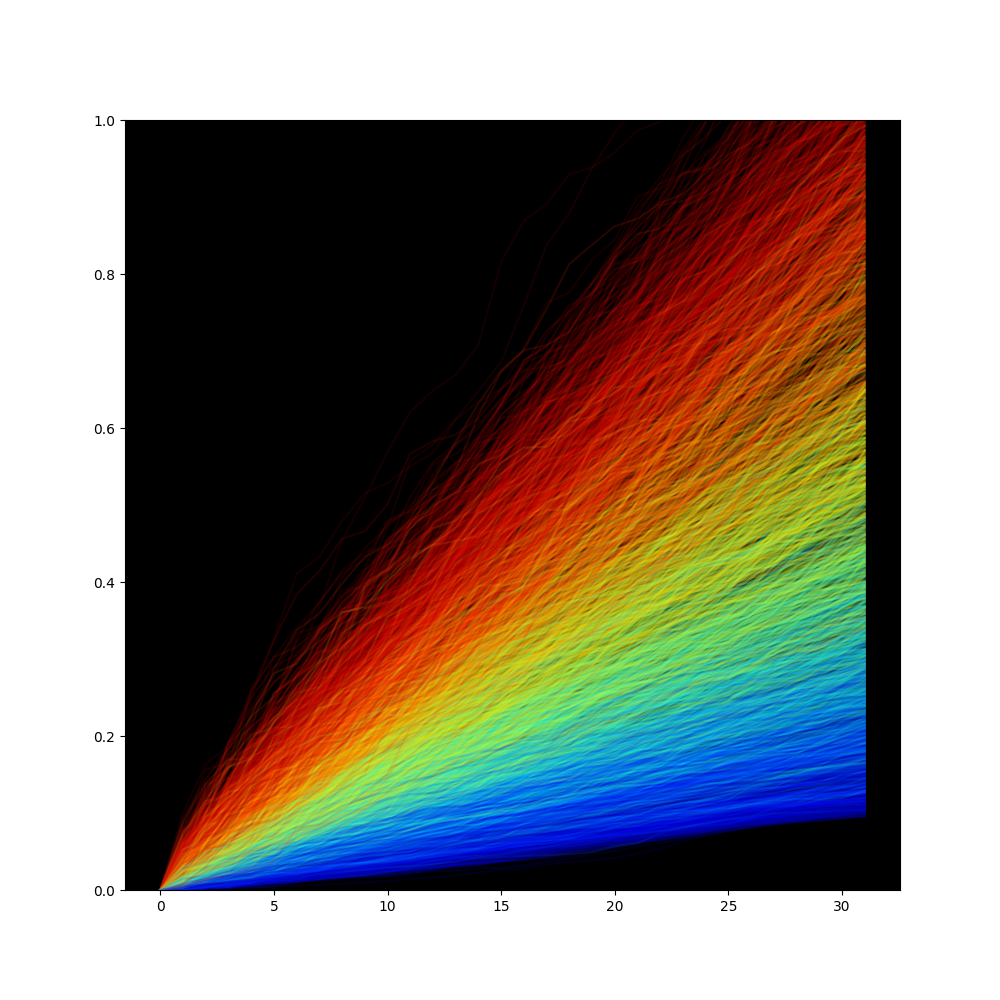

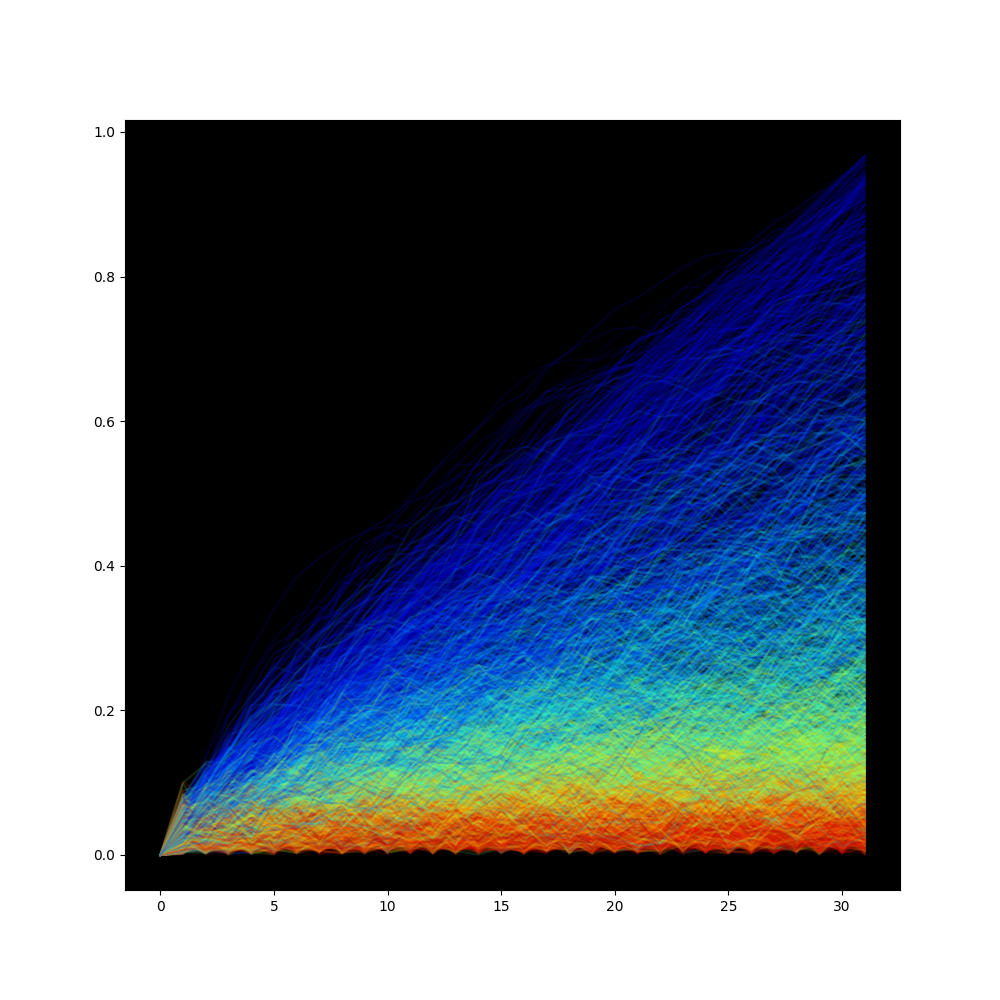

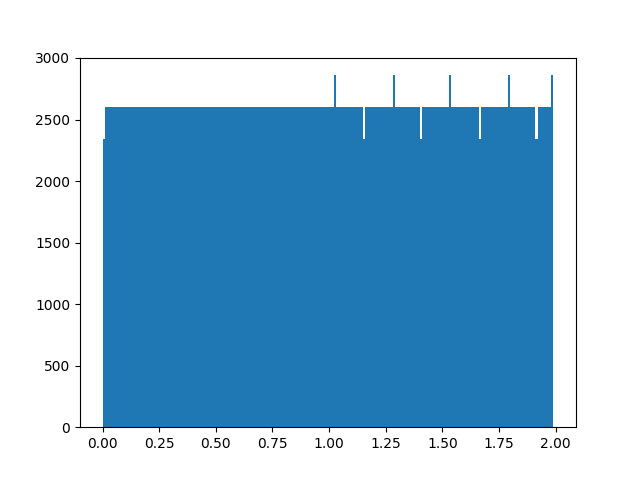

In [9]:
print(input_data.shape, input_label.shape)
colormap = 'jet'  # matplotlib colormap
mycmap = plt.get_cmap(colormap, lut=None)
color_seq = [mycmap(i)[:3] for i in range(mycmap.N)][::-1]

fig = plt.figure(figsize=(10,10))
ax = plt.axes()
ax.set_facecolor("black")
for i in range(0, 3000):
    color = color_seq[int(train_label[i]/2. * 255)]
    ax.plot(train_input[i, :, 0], color=color, alpha=0.15, zorder=-1)
ax.set_ylim([0, 1])

fig = plt.figure(figsize=(10,10))
ax = plt.axes()
ax.set_facecolor("black")
for i in range(0, 3000):
    color = color_seq[int(train_label[i]/2. * 255)]
    ax.plot(train_input[i, :, 1], color=color, alpha=0.15, zorder=-1)

plt.figure()
plt.hist(train_label, bins=np.arange(0, 2, 0.01))

In [10]:
train_input = train_input.reshape(-1, T, 1, 2)
train_label = train_label.reshape(-1, 1)
val_input = val_input.reshape(-1, T, 1, 2)
val_label = val_label.reshape(-1, 1)

In [11]:
print(f'train_reg_shape:{train_input.shape}\n',
      f'train_label_shape:{train_label.shape}\n'
      f'val_reg_shape:{val_input.shape}\n',
      f'val_label_shape:{val_label.shape}\n'
     )

train_reg_shape:(519740, 32, 1, 2)
 train_label_shape:(519740, 1)
val_reg_shape:(149925, 32, 1, 2)
 val_label_shape:(149925, 1)



In [19]:
# Shape [batch, time, features] => [batch, time, lstm_units]
reg_input = keras.Input(shape=(None, 1, 2), name="reg_signals")
x = layers.ConvLSTM1D(filters=128, kernel_size=2, strides=1,
                      padding='same', dropout=0.1, data_format="channels_last")(reg_input)
x = layers.ReLU()(x)
x = layers.Bidirectional(layers.LSTM(64, dropout=0.1))(x)
x = layers.ReLU()(x)
x = layers.Flatten()(x)
reg_dense = layers.Dense(units=64, activation='relu')(x)
reg_last_layer = layers.Dense(units=1)(reg_dense)

reg_model = keras.Model(
    inputs=[reg_input],
    outputs=[reg_last_layer],
    name='anomalous_regression'
)

In [20]:
reg_model.compile(loss=tf.keras.losses.MeanSquaredError(name='mean_squared_error'),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3/2),
                  metrics=[tf.keras.metrics.MeanAbsoluteError(name='MAE'),
                          ]
                 )
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=20,
                                                  mode='min',
                                                  verbose=1,
                                                  restore_best_weights=True,
                                                  start_from_epoch=3
                                                 )

In [21]:
reg_history = reg_model.fit(x=train_input,
                            y=train_label,
                            validation_data=(val_input, val_label),
                            batch_size=1024,
                            epochs=1500,
                            shuffle=True,
                            callbacks=[early_stopping],
                            verbose=2
                           )
reg_model.save(f'./models/reg_model_{T}.keras')
history_dict = reg_history.history
json.dump(history_dict, open(f'./models/reg_history_{T}.json', 'w'))

Epoch 1/1500


2024-05-31 09:10:14.666037: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-05-31 09:10:14.878837: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp_10.


KeyboardInterrupt: 

# Test

In [6]:
model_check = 32
test_N = 3
test_T = 200

In [15]:
regression_model = tf.keras.models.load_model(f'./models/alpha_reg_models/reg_model_{model_check}.keras')

In [8]:
test_data = []
test_label = []

for alpha in np.arange(0.001, 2, 0.001):
    D = np.random.uniform(low=0.01, high=10.0)
    trajs_model, labels_model = models_phenom().single_state(N=test_N,
                                                             L=None,
                                                             T=test_T,
                                                             alphas=alpha,
                                                             Ds=[D, 0],
                                                            )
    for n_traj in range(test_N):
        for _ in range(25):
            random_start = np.random.randint(0, test_T - model_check)
            xs = trajs_model[:, n_traj, 0][random_start:random_start + model_check]
            ys = trajs_model[:, n_traj, 1][random_start:random_start + model_check]
            rad_list = radius_list(xs, ys)
                
            xs = xs / (np.std(xs))
            xs = np.cumsum(abs(uncumulate(xs))) / len(xs)
            ys = ys / (np.std(ys))
            ys = np.cumsum(abs(uncumulate(ys))) / len(ys)
            test_data.append(np.vstack((((xs + ys) /2), rad_list)).T)
            test_label.append(alpha)

In [9]:
test_data = np.array(test_data).reshape(-1, model_check, 1, 2)
test_label = np.array(test_label).reshape(-1, 1)

In [10]:
pred = regression_model.predict(test_data)
print(f'MAE_valid: {np.mean(abs(pred - test_label))}')
grid = np.arange(-1, 3, 0.1)
H, xedges, yedges = np.histogram2d(test_label.flatten(), pred.flatten(), bins=(grid, grid), density=True)
print(np.hstack((test_label[:10], pred[:10])))

2024-05-31 16:34:30.222862: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8700


4686/4686 [==============================] - 132s 28ms/step
MAE_valid: 0.13818495850816334
[[0.001      0.09414766]
 [0.001      0.08071896]
 [0.001      0.119698  ]
 [0.001      0.16132462]
 [0.001      0.05731529]
 [0.001      0.07226137]
 [0.001      0.1204321 ]
 [0.001      0.10388716]
 [0.001      0.08916713]
 [0.001      0.08571699]]


(array([675., 750., 750., 750., 750., 750., 750., 750., 750., 750., 750.,
        750., 750., 750., 750., 750., 750., 750., 750., 750., 750., 750.,
        750., 750., 750., 750., 750., 750., 750., 750., 750., 750., 750.,
        750., 750., 750., 750., 750., 750., 750., 750., 750., 750., 750.,
        750., 750., 750., 750., 750., 750., 750., 750., 750., 750., 750.,
        750., 750., 750., 750., 750., 750., 750., 750., 750., 750., 750.,
        750., 750., 750., 750., 750., 750., 750., 750., 750., 750., 750.,
        750., 750., 750., 750., 750., 750., 750., 750., 750., 750., 750.,
        750., 750., 750., 750., 750., 750., 750., 750., 750., 750., 750.,
        750., 750., 750., 825., 750., 750., 750., 750., 750., 750., 750.,
        750., 750., 750., 750., 750., 675., 750., 750., 750., 750., 750.,
        750., 750., 750., 750., 750., 750., 750., 825., 750., 750., 750.,
        750., 750., 750., 750., 750., 750., 750., 750., 675., 750., 750.,
        750., 750., 750., 750., 750., 

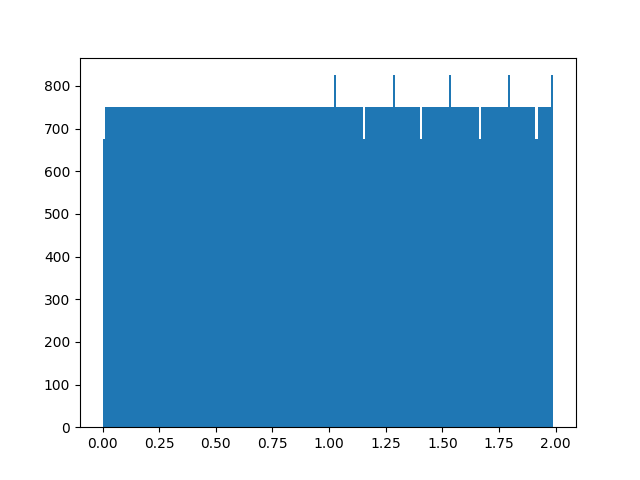

In [11]:
plt.figure()
plt.hist(test_label, bins=np.arange(0, 2, 0.01))

[Text(0.5, 214.44444444444443, 'True alpha'),
 Text(294.44444444444446, 0.5, 'Pred alpha')]

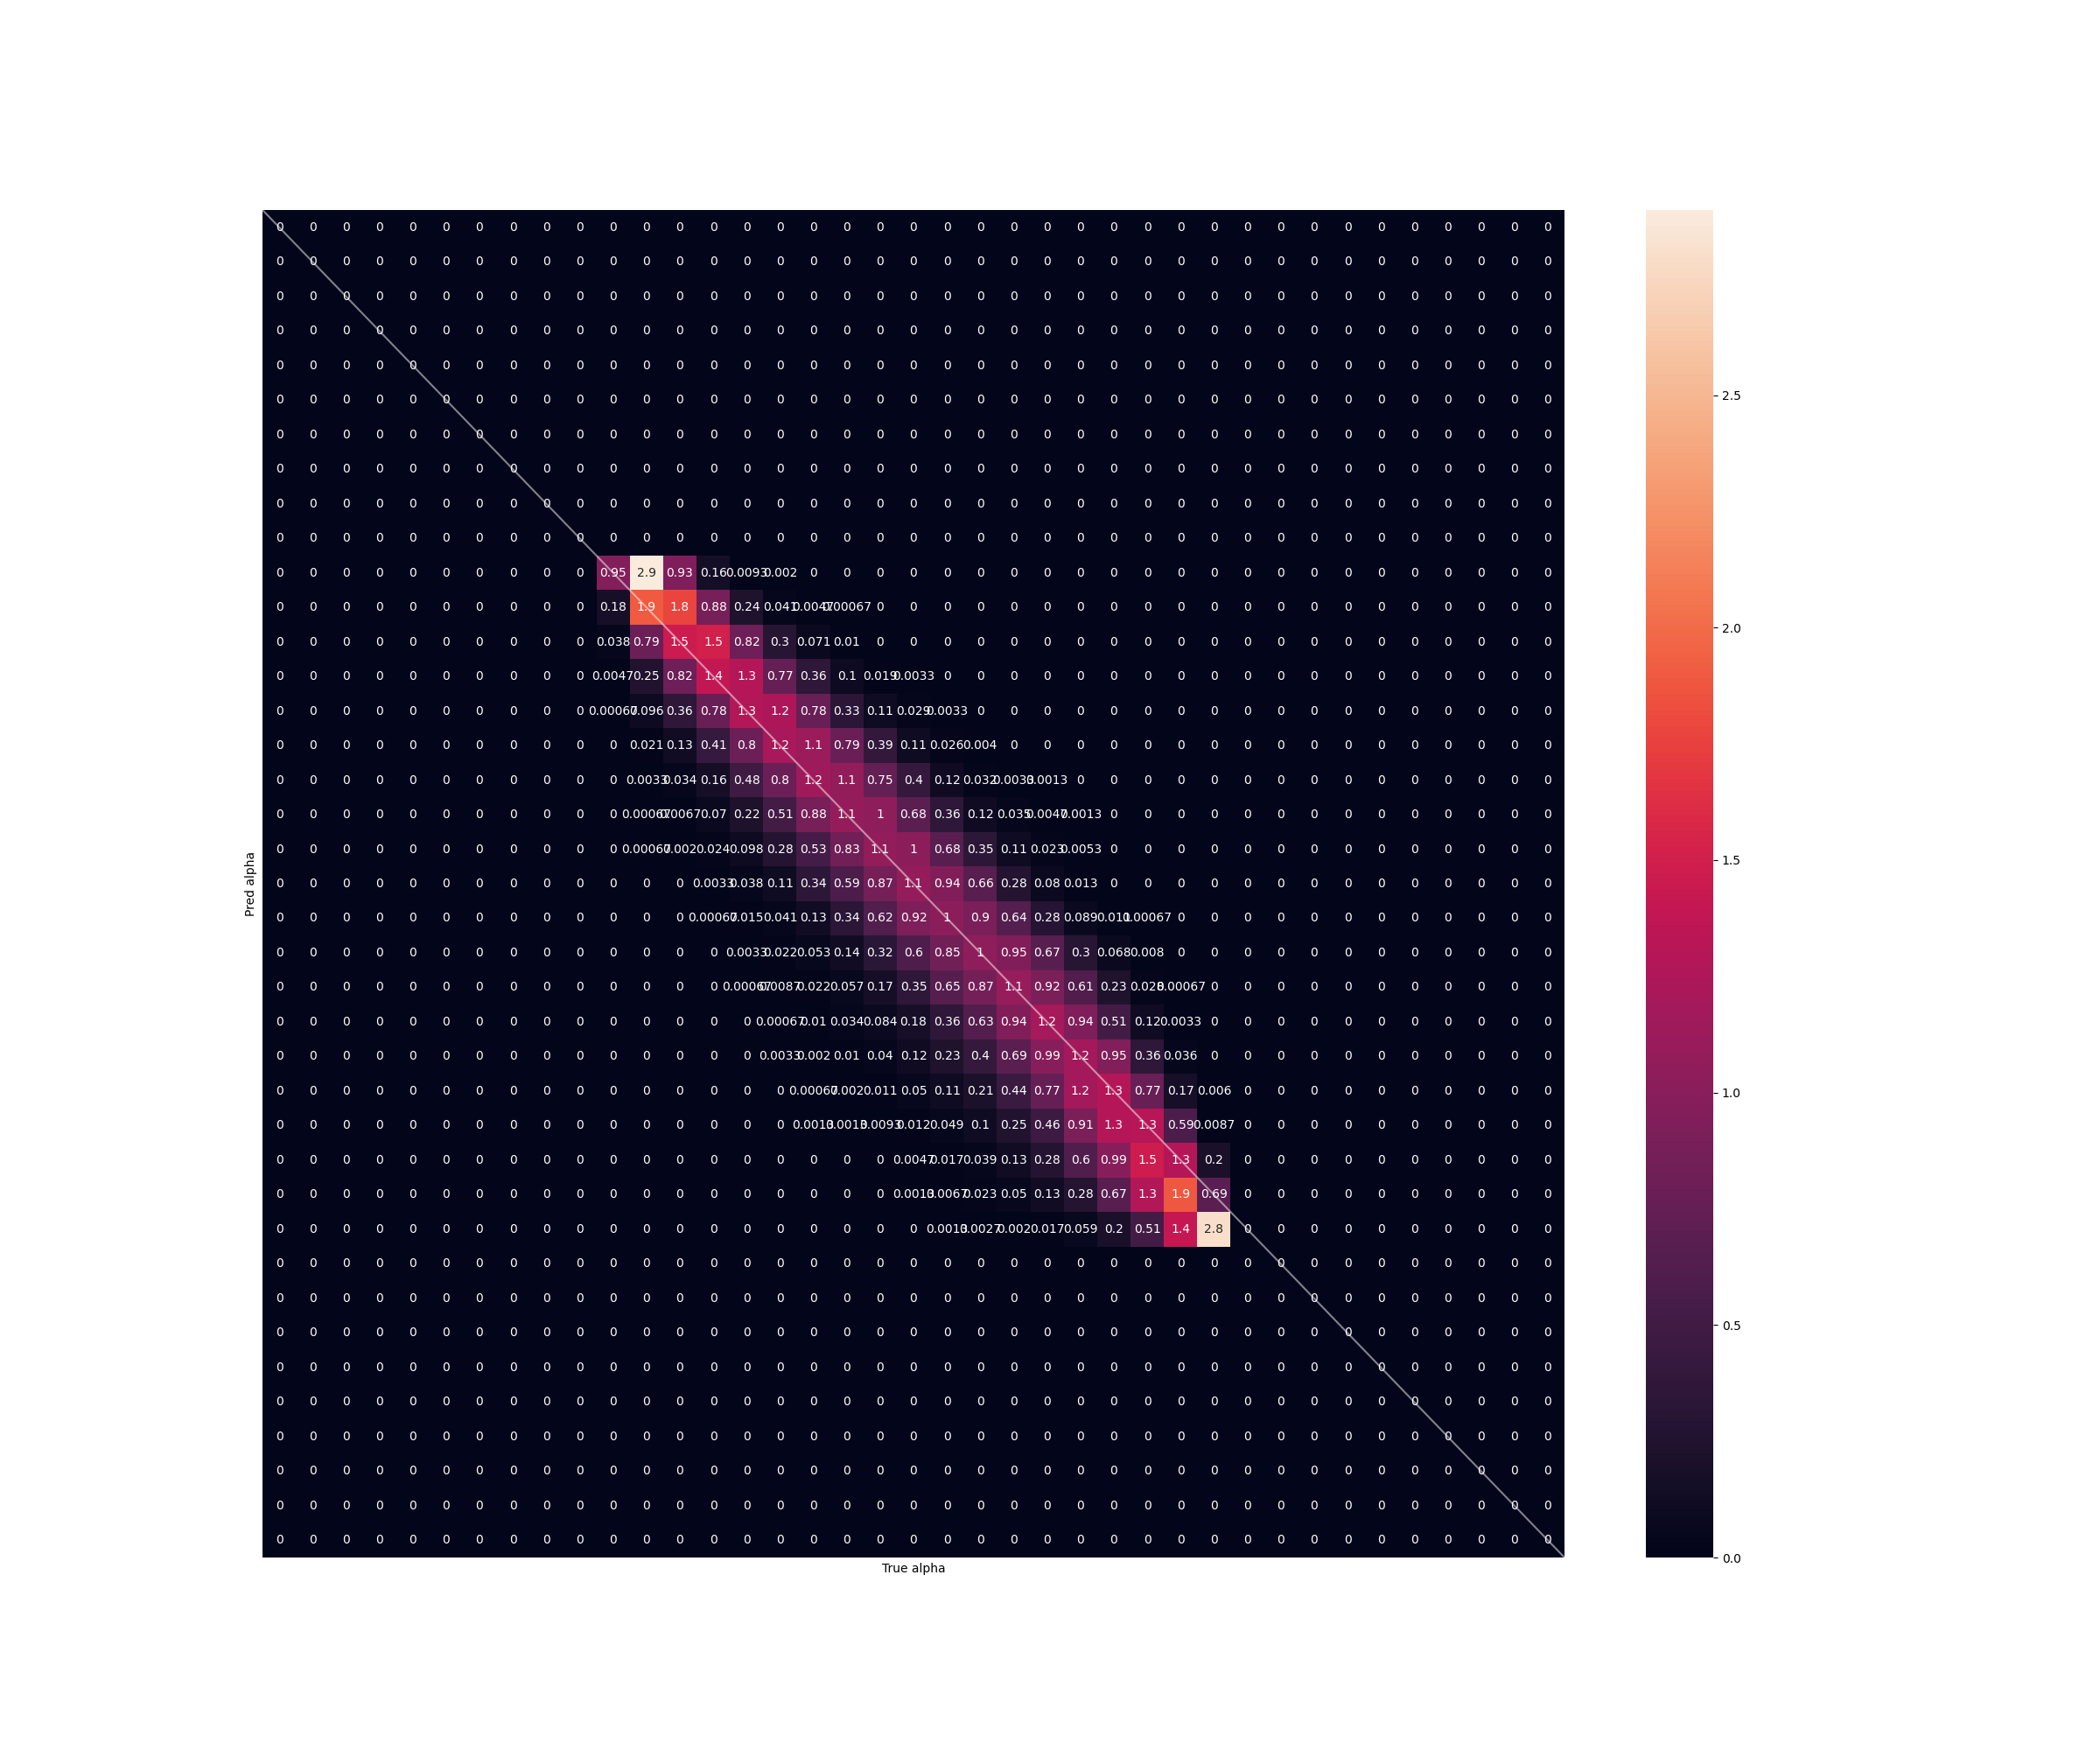

In [12]:
plt.figure(figsize=(24, 20))
ax = sns.heatmap(H, xticklabels=False, yticklabels=False, annot=True)
ax.plot([0, 255],[0, 255], c='white', alpha=0.5, *ax.get_xlim())
ax.set(xlabel='True alpha', ylabel='Pred alpha')

In [16]:
alpha_range = np.arange(0.001, 2, 0.1)
mae_mean = []
mae_stds = []
for alpha in alpha_range:
    test_data = []
    test_label = []

    D = np.random.uniform(low=0.01, high=10.0)
    trajs_model, labels_model = models_phenom().single_state(N=100,
                                                             L=None,
                                                             T=test_T,
                                                             alphas=alpha,
                                                             Ds=[D, 0],
                                                            )
    for n_traj in range(100):
        for _ in range(25):
            random_start = np.random.randint(0, test_T - model_check)
            xs = trajs_model[:, n_traj, 0][random_start:random_start + model_check]
            ys = trajs_model[:, n_traj, 1][random_start:random_start + model_check]
            rad_list = radius_list(xs, ys)
                
            xs = xs / (np.std(xs))
            xs = np.cumsum(abs(uncumulate(xs))) / len(xs)
            ys = ys / (np.std(ys))
            ys = np.cumsum(abs(uncumulate(ys))) / len(ys)
            test_data.append(np.vstack((((xs + ys) /2), rad_list)).T)
            test_label.append(alpha)
    test_data = np.array(test_data).reshape(-1, model_check, 1, 2)
    test_label = np.array(test_label).reshape(-1, 1)
    pred = regression_model.predict(test_data)
    mae_mean.append(np.mean(abs(pred - test_label)))
    mae_stds.append(np.std(abs(pred - test_label)))

79/79 [==============================] - 2s 27ms/step


0.14424783508543193 0.10564195687189656


(0.0, 0.5)

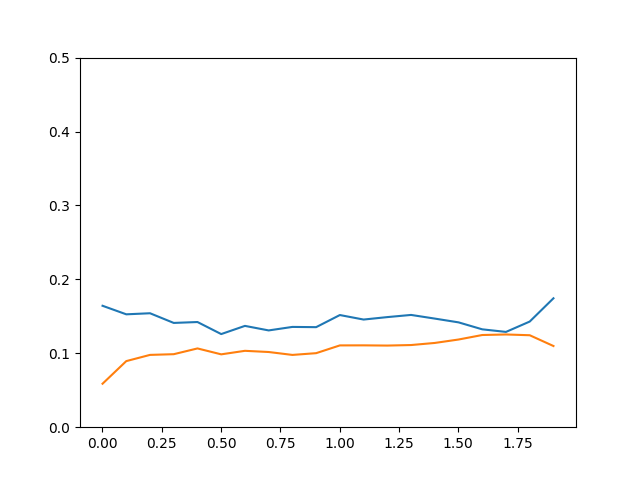

In [17]:
print(np.mean(mae_mean), np.mean(mae_stds))
plt.figure()
plt.plot(alpha_range, mae_mean)
plt.plot(alpha_range, mae_stds)
plt.ylim([0, 0.5])